In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as pl
import torch.nn.functional as F
import torchvision.models as models

In [2]:
from PIL import Image
from pathlib import Path
from bidict import bidict
from lime import lime_image
from typing import NamedTuple
from dataclasses import dataclass
from torchvision import transforms
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

/home/hope/Repositories/flower-eng-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from Models.CNN_model import CNN
from Models.VGG19_model import VGG19

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
cnn = CNN()
cnn.load_state_dict(torch.load("../assets/cnn_model.pth", map_location=device))
cnn.eval()

original_vgg19_model = models.vgg19(weights="VGG19_Weights.DEFAULT")
vgg = VGG19(original_vgg19_model)
vgg.load_state_dict(torch.load("../assets/vgg19_transfer.pth", map_location=device))
vgg.eval()

/tmp/ipykernel_12262/2562946536.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load("../assets/cnn_model.pth", map_location=device))
/tmp/ipyk

VGG19(
  (original_vgg19_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [6]:
image_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Normalize(
            mean=[0.1855, 0.1855, 0.1855], std=[0.2003, 0.2003, 0.2004]
        ),
    ]
)

preprocess_transform = transforms.ToTensor()

In [7]:
classes = bidict({0: "glioma", 1: "meningioma", 2: "notumor", 3: "pituitary"})

In [8]:
def choose_random_image():
    image_path = list(Path("../assets/Dataset/Testing/").glob("*/*.jpg"))
    image_path = random.choice(image_path)
    image_class = image_path.parent.stem

    image = Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize((224, 224))

    pl.rcParams.update({"font.size": 13})
    pl.figure(figsize=(6, 6))
    pl.imshow(image)
    pl.title(f"Orginal class = {image_class}")
    pl.axis("off")
    pl.show()

    return image

In [9]:
def get_model_prediction(model, image) -> int:
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.1855, 0.1855, 0.1855], std=[0.2003, 0.2003, 0.2004]
            ),
        ]
    )

    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch)

    return torch.argmax(output[0]).item()

In [10]:
@dataclass
class Params:
    num_samples: int
    num_features: int
    positive_only: bool

In [18]:
def explain_with_lime(model, image_path: str, image_class: int, params: Params):
    image = Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize((224, 224))
    print(f"Model prediction = {classes[get_model_prediction(model, image)]}")
    image = np.array(image)

    def batch_predict(images: np.ndarray) -> np.ndarray:
        model.eval()
        batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

        batch = batch.to(device)
        logits = model(batch)
        probs = F.softmax(logits, dim=1)

        return probs.detach().cpu().numpy()

    # segmenter = SegmentationAlgorithm(
    #     "quickshift",
    #     kernel_size=params.kernel_size,
    #     max_dist=params.max_dist,
    #     ratio=params.ratio,
    # )

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=batch_predict,
        # segmentation_fn=segmenter,
        num_samples=params.num_samples,
    )

    print(f"Top label = {classes[explanation.top_labels[0]]}")

    temp, mask = explanation.get_image_and_mask(
        label=image_class,
        positive_only=params.positive_only,
        num_features=params.num_features,
    )

    marked_image = mark_boundaries(temp / 255.0, mask)

    return marked_image

In [12]:
# image = choose_random_image()

# pl.figure(figsize=(10, 10))
# pl.title(image_title)
# pl.imshow(marked_image)
# pl.axis("off")

In [13]:
class Explanations(NamedTuple):
    image: np.ndarray
    description: str

In [14]:
samples = [100, 200, 300, 400, 500, 600, 700, 800, 1000]
explanations: list[Explanations] = []

for x in samples:
    params = Params(
        num_samples=x,
        num_features=2,
        positive_only=False,
    )

    image = (
        explain_with_lime(
            cnn,
            "../assets/test_pituitary.jpg",
            classes.inverse["pituitary"],
            params,
        ),
    )

    description = (f"Num samples = {x}",)
    explanations.append(Explanations(image, description))

Prediction = pituitary


100%|██████████| 100/100 [00:00<00:00, 143.31it/s]


Top label = pituitary
Prediction = pituitary


100%|██████████| 200/200 [00:01<00:00, 147.06it/s]


Top label = pituitary
Prediction = pituitary


100%|██████████| 300/300 [00:02<00:00, 116.81it/s]


Top label = pituitary
Prediction = pituitary


100%|██████████| 400/400 [00:04<00:00, 88.75it/s] 


Top label = pituitary
Prediction = pituitary


100%|██████████| 500/500 [00:18<00:00, 27.12it/s] 


Top label = pituitary
Prediction = pituitary


100%|██████████| 600/600 [00:04<00:00, 132.43it/s]


Top label = pituitary
Prediction = pituitary


100%|██████████| 700/700 [00:04<00:00, 147.97it/s]


Top label = pituitary
Prediction = pituitary


100%|██████████| 800/800 [00:06<00:00, 131.83it/s]


Top label = pituitary
Prediction = pituitary


100%|██████████| 1000/1000 [00:12<00:00, 77.10it/s]

Top label = pituitary


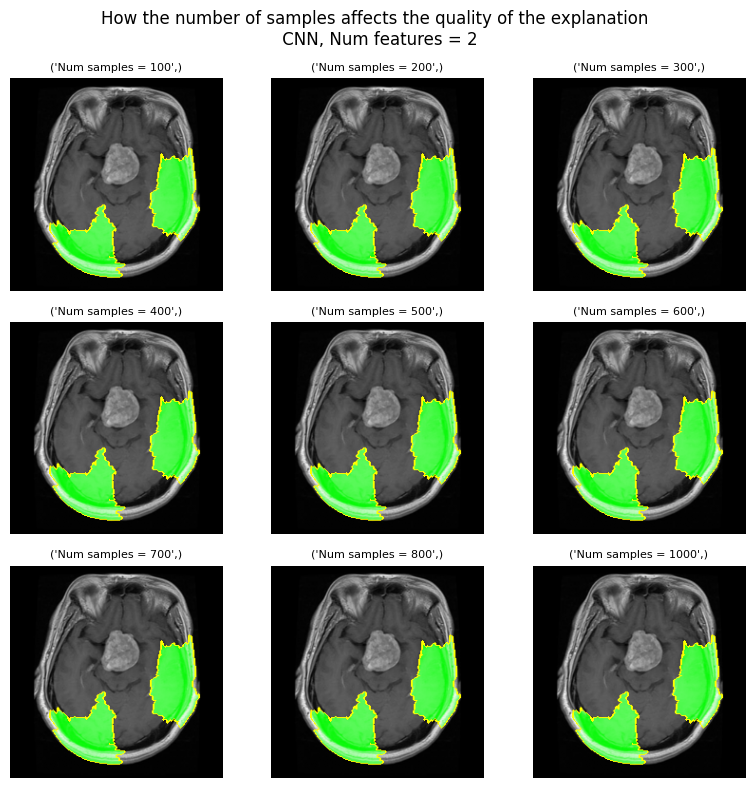

In [21]:
fig, axs = pl.subplots(3, 3, figsize=(8, 8))
image_ix = 0

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(explanations[image_ix].image[0])
        axs[i, j].set_title(explanations[image_ix].description, fontsize=8)
        axs[i, j].axis("off")
        image_ix += 1

pl.suptitle("How does the number of samples affect the quality of the explanation \n CNN, Num features = 2")
pl.tight_layout()
pl.show()

Prediction = pituitary


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Top label = pituitary


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

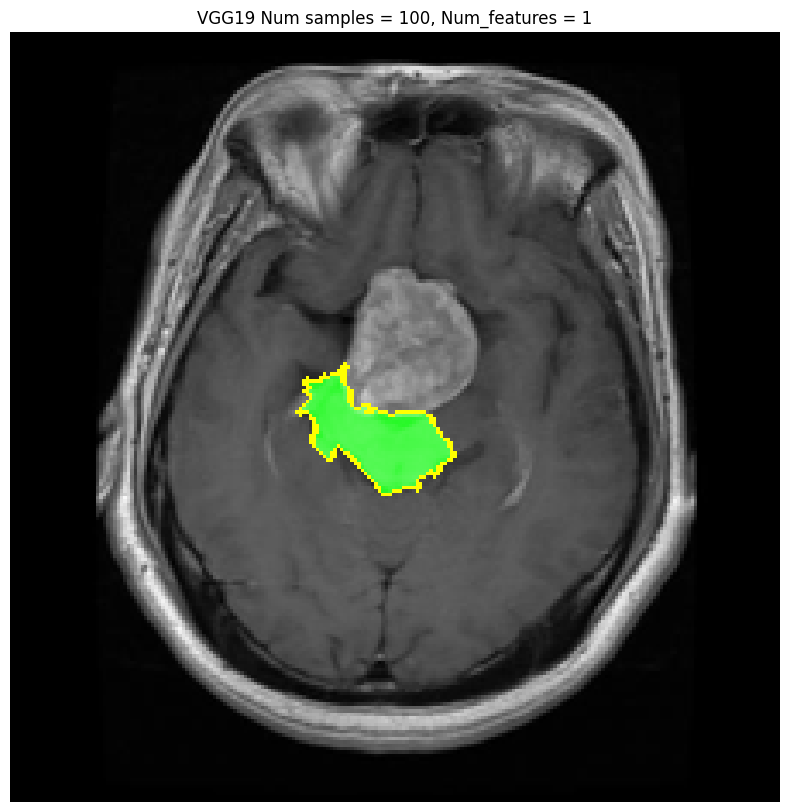

In [17]:
params = Params(num_samples=100, num_features=1, positive_only=False)
image = explain_with_lime(
    vgg,
    "../assets/test_pituitary.jpg",
    classes.inverse["pituitary"],
    params,
)

pl.figure(figsize=(10, 10))
pl.title(f"VGG19 Num samples = {params.num_samples}, Num_features = {params.num_features}")
pl.imshow(image)
pl.axis("off")